In [65]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [66]:
import math
import pandas as pd

class CheckUtils():
    def __init__(self) -> None:
        pass
    
    # def checkValue(func):
    #     from functools import partial
    #     partial 
    @staticmethod
    def checkSeries(serdf, 
                 isNan = True, 
                 isEmpty = True, 
                 isInf = True,
                    isNotInstance = None,
                    isNotIn = False,
                    isNotInVal = None
                 ):
        

        
        def _check_subsequent(x, 
                              isNotInstance = isNotInstance, 
                              isNan = isNan, 
                              isEmpty = isEmpty, 
                              isInf = isInf, 
                              isnotIn = isNotIn, 
                              isNotInVal = isNotInVal):
            out = False
            
            if isNotInstance is not None:
                x1 = (not isinstance(x, isNotInstance))
            else:
                x1 = False

            if isinstance(x, (int, float, complex)):
                x2 = pd.isna(x) if isNan else False
                x3 = math.isinf(x) if isInf else False
                x4 = False
            
            elif x == None:
                x2 = False
                x3 = False
                x4 = True if isEmpty else False
            
            else:
                x2 = False
                x3 = False
                x4 = (len(x) == 0) if isEmpty else False
                
            x5 = isNotInVal not in x if isNotIn else False

            return out | x1 | x2 | x3 | x4 | x5
        
        
        if isinstance(serdf, pd.Series):
            return serdf.map(lambda x: _check_subsequent(x))
        
        elif isinstance(serdf, pd.DataFrame):
            out  = serdf.map(lambda x: _check_subsequent(x)) # cellwise

            return out.apply(lambda x: any(x), axis = 1)
        
        else:
            raise ValueError("this is not either series or dataframe.")

    
    @staticmethod
    def isEmpty(dataframe) -> bool:
    
        if len(dataframe.index) == 0:
            return True
    
        return False

/home/hyohyeongjang/.conda/envs/hyohyeongjang_base/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for universal-dependencies/universal_dependencies contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/universal-dependencies/universal_dependencies
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/hyohyeongjang/.conda/envs/hyohyeongjang_base/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for ontonotes/conll2012_ontonotesv5 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ontonotes/conll2012_ontonotesv5
You can avoid this message in future by passing the argument `trust_remot

/home/hyohyeongjang/dependency_bert/finetuning/POS/dependency/checkpoint-3400 /home/hyohyeongjang/dependency_bert/finetuning/POS/random/checkpoint-3400 /home/hyohyeongjang/dependency_bert/finetuning/POS/base/checkpoint-3400
/home/hyohyeongjang/dependency_bert/finetuning/DEP/dependency/checkpoint-3400 /home/hyohyeongjang/dependency_bert/finetuning/DEP/random/checkpoint-3400 /home/hyohyeongjang/dependency_bert/finetuning/DEP/base/checkpoint-3400


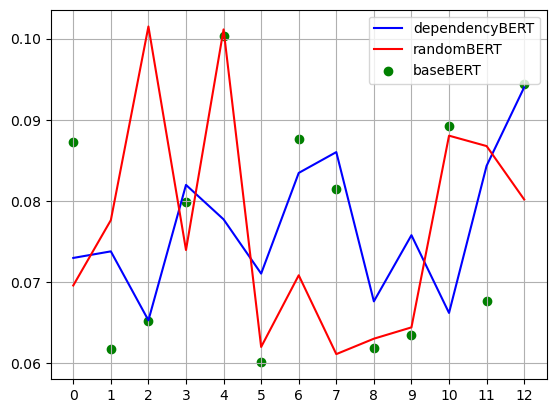

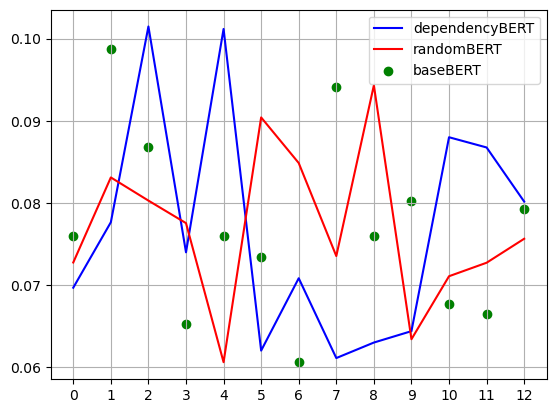

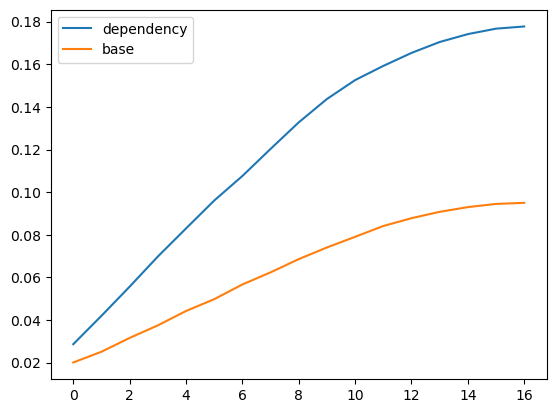

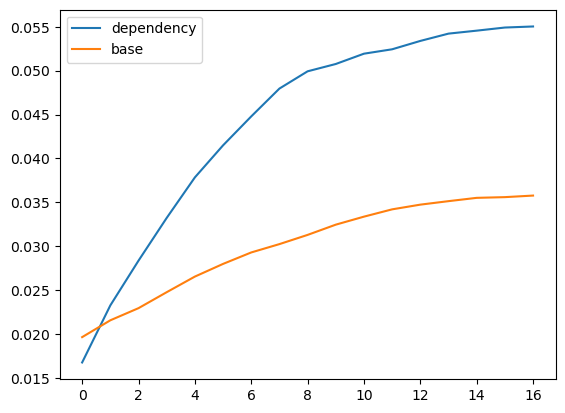

In [67]:
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoModelForTokenClassification, BertForTokenClassification
from functools import partial
from datasets import load_dataset
import evaluate
import numpy as np
import pandas as pd
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

from transformers import DataCollatorForTokenClassification
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers.modeling_outputs import TokenClassifierOutput
from torch.nn.modules.loss import CrossEntropyLoss
from safetensors.torch import load_model, save_model
import os

from matplotlib import pyplot as plt
import json


class FineTuningTrainer():
    # def __init__(self, train_dataset, eval_dataset, tokenizer, num_labels, metrics, device, task):
    def __init__(self, data, tokenizer, num_labels, metrics, device, task, epoch):
        self.task = task
        self.tokenizer = tokenizer
        
        if task == "pos":   self.tokenized_data = data.map(self._tokenize_and_aligh_labels_pos, batched = True)
        if task == "dep":   self.tokenized_data = data.map(self._tokenize_and_align_labels_dep, batched = True)
        if task == "srl":   self.tokenized_data = data.map(self._tokenize_and_align_labels_srl, batched = True)

        # self.train_dataset = train_dataset.map(partial(self._tokenize_and_align_labels, task = task), batched = True)
        # self.eval_dataset = eval_dataset.map(partial(self._tokenize_and_align_labels, task = task), batched = True)
        
        self.train_dataset = self.tokenized_data['train']
        self.eval_dataset = self.tokenized_data['validation']
        self.num_labels = num_labels
        self.metrics = metrics
        self.collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
        self.device = device
        self.epoch = epoch
    
    def train(self, *, checkpoint, types):
    
        print(f"{types} training starts")
            
        model = AutoModel.from_pretrained(checkpoint, output_hidden_states = True)
        for param in model.parameters():
            param.requires_grad = False
        if self.task == "pos":  my_model = My_modelForPOS(model, self.device, 13, 768, self.num_labels)
        else:                   my_model = My_modelForDep(model, self.device, 13, 768, self.num_labels)
        my_model.to(self.device)
        
        if self.task == "pos": loc = "POS"
        if self.task == "dep": loc = "DEP"
        if self.task == "srl": loc = "SRL"

        training_args = TrainingArguments(output_dir = f"finetuning/{loc}/{types}",
                                          eval_strategy="steps",
                                          eval_steps=200,
                                          save_steps=200,
                                          save_total_limit=1,
                                          load_best_model_at_end=True,
                                          save_only_model=True,
                                          greater_is_better=True,
                                          num_train_epochs=self.epoch,
                                          seed=42,
                                          per_device_train_batch_size=2048,
                                          per_device_eval_batch_size=2048,
                                          learning_rate=1e-6,
                                          weight_decay=0.0001,
                                          metric_for_best_model="f1"
                                          )

        if self.task == "pos": metric_func = self._compute_metrics_pos
        if self.task == "dep": metric_func = self._compute_metrics_dep
        if self.task == "srl": metric_func = self._compute_metrics_srl

        trainer = Trainer(model = my_model,
                        args=training_args,
                        train_dataset=self.train_dataset,
                        eval_dataset=self.eval_dataset,
                        compute_metrics=metric_func,
                        callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
                        )
        
        trainer.train()
        print(f"{types} training ends")


################################################################################################################

    def _tokenize_and_aligh_labels_pos(self, examples):
        max_length = 128
        labels_froms = [[part_sentence['pos_tags'] for part_sentence in sentence] for sentence in examples['sentences']]
        labels_froms = [[token for part_sentence in sentence for token in part_sentence] for sentence in labels_froms]
        sents = [[part_sentence['words'] for part_sentence in sentence] for sentence in examples['sentences']]
        sents = [[token for part_sentence in sentence for token in part_sentence] for sentence in sents]
        examples['tokens'] = sents

        # 공통
        tokenized_inputs = self.tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding = "max_length", max_length = max_length, return_tensors = "pt")
        labels = []

        for sentence_idx, label in enumerate(labels_froms):
            
            word_ids = tokenized_inputs.word_ids(batch_index=sentence_idx)  # Map tokens to their respective word.
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:  # Set the special tokens and padding to -100.
                
                if (word_idx != None) and (word_idx != previous_word_idx) and (label[word_idx] != None): 
                    pos_label = label[word_idx] # pos speical                   
                    label_ids.append(pos_label) # pos speical
                else:
                    label_ids.append(-100)
                
                previous_word_idx = word_idx
            labels.append(label_ids)

        labels = [[-100 if not isinstance(i, int) else i for i in j] for j in labels]
        tokenized_inputs["labels"] = torch.tensor(labels, requires_grad=False)

        return tokenized_inputs
    
    def _compute_metrics_pos(self, pred):

        # import numpy as np
        # labels = [label_list[i] for i in example[f"ner_tags"]]

        predictions, labels = pred
        predictions = np.argmax(predictions, axis=2)

        true_predictions = [
            [p for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [l for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_predictions = [j for i in true_predictions for j in i]
        true_labels = [j for i in true_labels for j in i]

        results = self.metrics.compute(predictions=true_predictions, references=true_labels, average="micro")
        return results
    
################################################################################################################

    def _tokenize_and_align_labels_dep(self, examples):
          
        max_length = 128

        labels_froms = [[eval(token)[0] if eval(token) != None else ("", -100) for token in sentence] for sentence in examples[f"deps"]]
        labels_role = [[token[0] for token in sent] for sent in labels_froms]
        x = [i for j in labels_role for i in j]
        x = pd.Series(x).map(lambda x: x.split(":")[0]).drop_duplicates().values
        
        label2id_role = {i: j for j, i in enumerate(x)}
        id_role = [[label2id_role[token.split(":")[0]] for token in sentence] for sentence in labels_role]  

        ids_position = [[token[1] for token in sentence] for sentence in labels_froms]
        
        

        # return froms, examples

        tokenized_inputs = self.tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding = "max_length", max_length = max_length, return_tensors = "pt")
        labels_position = []
        labels_role = []
        
        for sentence_idx, label_position_role  in enumerate(zip(ids_position, id_role)):
            label_position, label_role = label_position_role

            word_ids = tokenized_inputs.word_ids(batch_index=sentence_idx)  # Map tokens to their respective word.
            previous_word_idx = None
            lab_role = []
            lab_position = []
            for word_idx in word_ids:  # Set the special tokens and padding to -100.
                
                if (word_idx != None) and (word_idx != previous_word_idx) and (label_position[word_idx] != None): 
                    lab_position.append(label_position[word_idx]) # pos speical
                    
                    if label_role[word_idx] < max_length: 
                        lab_role.append(label_role[word_idx])
                    else:
                        lab_role.append(-100)
                else:
                    lab_position.append(-100)
                    lab_role.append(-100)
                
                previous_word_idx = word_idx
            
            labels_position.append(lab_position)
            labels_role.append(lab_role)

        labels_position = [[-100 if not isinstance(i, int) else i for i in j] for j in labels_position]
        labels_role = [[-100 if not isinstance(i, int) else i for i in j] for j in labels_role]
    
        whole_labels = torch.stack([torch.tensor(labels_position, requires_grad=False), torch.tensor(labels_role, requires_grad=False)])
        tokenized_inputs["labels"] = whole_labels.permute(1,0,2)

        return tokenized_inputs

    
    def _compute_metrics_dep(self, pred):

        predictions, labels = pred
        labels_position = labels[:,0,...]
        labels_role = labels[:,1,...]

        predictions_position = np.argmax(predictions[...,:128], axis = -1)
        predictions_role = np.argmax(predictions[...,128:], axis = -1)

        pp = [
            [p for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions_position, labels_position)
        ]
        lp = [
            [l for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions_position, labels_position)
        ]
        pp = [j for i in pp for j in i]
        lp = [j for i in lp for j in i]

        
        
        pr = [
            [p for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions_role, labels_role)
        ]
        lr = [
            [l for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions_role, labels_role)
        ]
        pr = [j for i in pr for j in i]
        lr = [j for i in lr for j in i]


        results1 = self.metrics.compute(predictions=pp, references=lp, average="micro")
        results2 = self.metrics.compute(predictions=pr, references=lr, average="micro")

        result = dict()
        result['f1'] = (results1['f1'] + results2['f1']) / 2

        return result
    
################################################################################################################

    def _tokenize_and_aligh_labels_srl(self, examples):
        max_length = 128
        labels_froms = [[part_sentence['pos_tags'] for part_sentence in sentence] for sentence in examples['sentences']]
        labels_froms = [[token for part_sentence in sentence for token in part_sentence] for sentence in labels_froms]
        sents = [[part_sentence['words'] for part_sentence in sentence] for sentence in examples['sentences']]
        sents = [[token for part_sentence in sentence for token in part_sentence] for sentence in sents]
        examples['tokens'] = sents

        # 공통
        tokenized_inputs = self.tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding = "max_length", max_length = max_length, return_tensors = "pt")
        labels = []

        for sentence_idx, label in enumerate(labels_froms):
            
            word_ids = tokenized_inputs.word_ids(batch_index=sentence_idx)  # Map tokens to their respective word.
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:  # Set the special tokens and padding to -100.
                
                if (word_idx != None) and (word_idx != previous_word_idx) and (label[word_idx] != None): 
                    pos_label = label[word_idx] # pos speical                   
                    label_ids.append(pos_label) # pos speical
                else:
                    label_ids.append(-100)
                
                previous_word_idx = word_idx
            labels.append(label_ids)

        labels = [[-100 if not isinstance(i, int) else i for i in j] for j in labels]
        tokenized_inputs["labels"] = torch.tensor(labels, requires_grad=False)

        return tokenized_inputs
    
    def _compute_metrics_srl(self, pred):

        # import numpy as np
        # labels = [label_list[i] for i in example[f"ner_tags"]]

        predictions, labels = pred
        predictions = np.argmax(predictions, axis=2)

        true_predictions = [
            [p for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [l for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_predictions = [j for i in true_predictions for j in i]
        true_labels = [j for i in true_labels for j in i]

        results = self.metrics.compute(predictions=true_predictions, references=true_labels, average="micro")
        return results
    
    
class My_modelForPOS(nn.Module):
    def __init__(self, model, device, num_layer, hidden_dim, num_labels):
        super(My_modelForPOS, self).__init__()
        self.model = model
        self.scalar = nn.Linear(in_features=num_layer, out_features=1, bias = False)
        self.dropout = nn.Dropout(p = 0.1)
        self.output = nn.Linear(in_features=hidden_dim, out_features=num_labels, bias = True)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels):
        # self.scalar.weight = nn.Parameter(torch.softmax(self.scalar.weight, dim = 1))
        inputs = {"input_ids": input_ids, "attention_mask": attention_mask}
        out = self.model(**inputs).hidden_states
        out = torch.stack(out)
        out = out.permute(1,2,3,0).contiguous() # layers, batch, sequence, hidden_dimension -> batch, sequence, hidden_dimension, layers
        out = self.scalar(out).squeeze() # batch, sequence, hidden_dimension, layers -> batch, sequence, hidden_dimension
        logits = self.output(self.dropout(out)) # batch, sequence, hidden_dimension -> batch, sequence, labels

        # from BertForTokenClassification
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # if not return_dict:
        #     output = (logits,) + outputs[2:]
        #     return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None
            # attentions=outputs.attentions,
        )
    



class My_modelForDep(nn.Module):
    def __init__(self, model, device, num_layer, hidden_dim, num_labels):
        super(My_modelForDep, self).__init__()
        self.max_length = 128

        self.model = model
        self.scalar = nn.Linear(in_features=num_layer, out_features=1, bias = False)
        self.dropout = nn.Dropout(p = 0.1)
        self.output = nn.Linear(in_features=hidden_dim, out_features=self.max_length + num_labels, bias = True)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels): # max labels_position : 37
        # self.scalar.weight = nn.Parameter(torch.softmax(self.scalar.weight, dim = 1))

        inputs = {"input_ids": input_ids, "attention_mask": attention_mask}
        out = self.model(**inputs).hidden_states
        out = torch.stack(out)
        out = out.permute(1,2,3,0).contiguous() # layers, batch, sequence, hidden_dimension -> batch, sequence, hidden_dimension, layers
        out = self.scalar(out).squeeze() # batch, sequence, hidden_dimension, layers -> batch, sequence, hidden_dimension
        logits = self.output(self.dropout(out)) # batch, sequence, hidden_dimension -> batch, sequence, num_labels

        
        logits_position = logits[...,:self.max_length].contiguous() # 0 ~ max_length(128)-1: 128
        logits_role = logits[...,self.max_length:].contiguous() # max_length(128) ~ : self.num_labels
        # from BertForTokenClassification
        loss = None
        loss_fct = CrossEntropyLoss()

        labels_position = labels[:,0,...].contiguous() # 첫 번째 디멘션은 배치같은데 이게 맞나?
        labels_role = labels[:,1,...].contiguous() # 첫 번째 디멘션은 배치같은데 이게 맞나?

        if labels_position is not None: loss1 = loss_fct(logits_position.view(-1, self.max_length), labels_position.view(-1))
        else:                           loss1 = loss_fct(torch.zeros(1), torch.zeros(1))
        if labels_role is not None:     loss2 = loss_fct(logits_role.view(-1, self.num_labels), labels_role.view(-1))
        else:                           loss2 = loss_fct(torch.zeros(1), torch.zeros(1))

        # if not return_dict:
        #     output = (logits,) + outputs[2:]
        #     return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss1 + loss2,
            logits=logits,
            hidden_states=None
            # attentions=outputs.attentions,
        )


class My_modelForSRL(nn.Module):
    def __init__(self, model, device, num_layer, hidden_dim, num_labels):
        super(My_modelForSRL, self).__init__()
        self.max_length = 128

        self.model = model
        self.scalar = nn.Linear(in_features=num_layer, out_features=1, bias = False)
        self.dropout = nn.Dropout(p = 0.1)
        self.output = nn.Linear(in_features=hidden_dim, out_features=self.max_length + num_labels, bias = True)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels): # max labels_position : 37
        # self.scalar.weight = nn.Parameter(torch.softmax(self.scalar.weight, dim = 1))

        inputs = {"input_ids": input_ids, "attention_mask": attention_mask}
        out = self.model(**inputs).hidden_states
        out = torch.stack(out)
        out = out.permute(1,2,3,0).contiguous() # layers, batch, sequence, hidden_dimension -> batch, sequence, hidden_dimension, layers
        out = self.scalar(out).squeeze() # batch, sequence, hidden_dimension, layers -> batch, sequence, hidden_dimension
        logits = self.output(self.dropout(out)) # batch, sequence, hidden_dimension -> batch, sequence, num_labels

        
        logits_position = logits[...,:self.max_length].contiguous() # 0 ~ max_length(128)-1: 128
        logits_role = logits[...,self.max_length:].contiguous() # max_length(128) ~ : self.num_labels
        # from BertForTokenClassification
        loss = None
        loss_fct = CrossEntropyLoss()

        labels_position = labels[:,0,...].contiguous() # 첫 번째 디멘션은 배치같은데 이게 맞나?
        labels_role = labels[:,1,...].contiguous() # 첫 번째 디멘션은 배치같은데 이게 맞나?

        if labels_position is not None: loss1 = loss_fct(logits_position.view(-1, self.max_length), labels_position.view(-1))
        else:                           loss1 = loss_fct(torch.zeros(1), torch.zeros(1))
        if labels_role is not None:     loss2 = loss_fct(logits_role.view(-1, self.num_labels), labels_role.view(-1))
        else:                           loss2 = loss_fct(torch.zeros(1), torch.zeros(1))

        # if not return_dict:
        #     output = (logits,) + outputs[2:]
        #     return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss1 + loss2,
            logits=logits,
            hidden_states=None
            # attentions=outputs.attentions,
        )


##########################################여기서부터#########################################
class Postprocessor():
    def __init__(self, device, num_labels, pretrained_checkpoint, types):
        self.device = device
        self.num_labels = num_labels
        self.pretrained_checkpoint = pretrained_checkpoint
        self.type = types
        pass

    def process(self, output_checkpoint):
        
        ptm = AutoModel.from_pretrained(self.pretrained_checkpoint)
        if self.type == "pos": my_model = My_modelForPOS(ptm, self.device, 13, 768, self.num_labels)        
        if self.type == "dep": my_model = My_modelForDep(ptm, self.device, 13, 768, self.num_labels)
        if self.type == "srl": my_model = My_modelForSRL(ptm, self.device, 13, 768, self.num_labels)
        load_model(my_model, output_checkpoint + "/model.safetensors")

        scalar_weight = my_model.scalar.weight.squeeze() 
        return torch.softmax(scalar_weight, dim = 0)
    
    def weighted_sum(self, weight_tensor_dict):
        
        return {key: (weight_tensor_dict[key].detach().numpy() * range(len(weight_tensor_dict[key]))).sum() for key in weight_tensor_dict}
    
    def load_accuracy(self, output_checkpoint):
        with open(output_checkpoint + "/trainer_state.json", "r") as f:
            lines = json.load(f)
            
        return [(i['step'], i['eval_f1']) for i in lines['log_history'] if 'eval_f1' in i.keys()]




    
##########################################여기까지는 scalar weight를 위한 postprocessor#########################################



# def main(*, checkpoint):
def main(*, data_dep, data_pos, data_srl, tokenizer, metrics, device, model_dep, model_random, model_base):

    num_labels_dependency = 37
    num_labels_pos = 49 # 아니 이거 왜 49면 돌아가지
    num_labels_srl = 1

    # stage 1
    
    # fineTuningTrainerForPOS = FineTuningTrainer(data_pos, tokenizer, num_labels_pos, metrics, device, "pos", epoch = 3500)

    # fineTuningTrainerForPOS.train(checkpoint = model_dep, types="dependency")
    # fineTuningTrainerForPOS.train(checkpoint = model_random, types="random")
    # fineTuningTrainerForPOS.train(checkpoint = model_base, types="base")
    


    # fineTuningTrainerForDep = FineTuningTrainer(data_dep, tokenizer, num_labels_dependency, metrics, device, "dep", epoch = 500)

    # fineTuningTrainerForDep.train(checkpoint = model_dep, types="dependency")
    # fineTuningTrainerForDep.train(checkpoint = model_random, types="random")
    # fineTuningTrainerForDep.train(checkpoint = model_base, types="base")


    # # unconducted
    # # fineTuningTrainerForSRL = FineTuningTrainer(data_srl, tokenizer, num_labels_srl, metrics, device, "srl")

    # # fineTuningTrainerForSRL.train(checkpoint = model_dep, types="dependency")
    # # fineTuningTrainerForSRL.train(checkpoint = model_random, types="random")
    # # fineTuningTrainerForSRL.train(checkpoint = model_base, types="base")


    # stage 2 # 수정 필요

    model_dep = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/POS/dependency/")[0]
    model_random = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/POS/random/")[0]
    model_base = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/POS/base/")[0]
    
    url_base = "/home/hyohyeongjang/dependency_bert/finetuning/POS/"
    model_dep = url_base + "dependency/" + model_dep 
    model_random = url_base + "random/" + model_random 
    model_base = url_base + "base/" + model_base 
    
    print(model_dep, model_random, model_base)

    postprocessor_pos = Postprocessor(device, num_labels_pos, base_model, types = "pos")

    out_pos = {"dependency": postprocessor_pos.process(model_dep),
     "random": postprocessor_pos.process(model_random),
     "base": postprocessor_pos.process(model_base)}
    
    score_pos = {"dependency":postprocessor_pos.load_accuracy(model_dep) ,
                 "random":postprocessor_pos.load_accuracy(model_random),
                 "base":postprocessor_pos.load_accuracy(model_base)}
    

    model_dep = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/DEP/dependency/")[0]
    model_random = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/DEP/random/")[0]
    model_base = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/DEP/base/")[0]

    url_base = "/home/hyohyeongjang/dependency_bert/finetuning/DEP/"
    model_dep = url_base + "dependency/" + model_dep 
    model_random = url_base + "random/" + model_random 
    model_base = url_base + "base/" + model_base 

    print(model_dep, model_random, model_base)

    postprocessor_dep = Postprocessor(device, num_labels_dependency, base_model, types = "dep")

    out_dep = {"dependency": postprocessor_dep.process(model_dep),
     "random": postprocessor_dep.process(model_random),
     "base": postprocessor_dep.process(model_base)}

    score_dep = {"dependency":postprocessor_pos.load_accuracy(model_dep) ,
                 "random":postprocessor_pos.load_accuracy(model_random),
                 "base":postprocessor_pos.load_accuracy(model_base)}
    
    # unconducted
    # model_dep = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/SRL/dependency/")[0]
    # model_random = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/SRL/random/")[0]
    # model_base = os.listdir("/home/hyohyeongjang/dependency_bert/finetuning/SRL/base/")[0]

    # postprocessor_srl = Postprocessor(device, num_labels_pos, num_labels_dependency, num_labels_srl, base_model, types = "srl")

    # out_dep = {"dependency": postprocessor_srl.process(model_dep),
    #  "random": postprocessor_srl.process(model_random),
    #  "base": postprocessor_srl.process(model_base)}
    
    
    return out_pos, out_dep, score_pos, score_dep

    # return out

if __name__ == "__main__":
#loaded
    # glob
    base_model = "google-bert/bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    metrics= evaluate.load("f1")

    # in func
    data_dependency = load_dataset("universal-dependencies/universal_dependencies", "en_ewt" )
    data_dependency = data_dependency.remove_columns(['text', 'xpos',  'feats', 'head', 'deprel', 'upos', 'misc', 'lemmas'])
    data_srl = load_dataset("ontonotes/conll2012_ontonotesv5", 'english_v4')
    data_srl = data_srl
    data_pos = load_dataset("ontonotes/conll2012_ontonotesv5", 'english_v4')
    data_pos = data_pos
    

    model_dep = "/home/hyohyeongjang/dependency_bert/checkpoint_output_dependency/checkpoint-dependency-high/"
    model_random = "/home/hyohyeongjang/dependency_bert/checkpoint_output_random/checkpoint-random-high/"
    model_base = "google-bert/bert-base-uncased"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    output_pos, output_dep, score_pos, score_dep = main(data_dep = data_dependency, 
             data_pos = data_pos,
             data_srl = data_srl,
               tokenizer=tokenizer, 
               metrics=metrics, 
               device= device, 
               model_dep=model_dep, 
               model_random=model_random, 
               model_base=model_base)
    
    
    out = output_pos
    plt.plot(range(13), out['dependency'].detach().numpy(), c = "b")
    plt.plot(range(13), out['random'].detach().numpy(), c = "r")
    plt.scatter(range(13), out['base'].detach().numpy(), c = "g")
    plt.legend(['dependencyBERT', "randomBERT", "baseBERT"])
    plt.xticks(range(13))

    plt.grid(visible = True)
    plt.show()


    out = output_dep
    plt.plot(range(13), out['dependency'].detach().numpy(), c = "b")
    plt.plot(range(13), out['random'].detach().numpy(), c = "r")
    plt.scatter(range(13), out['base'].detach().numpy(), c = "g")
    plt.legend(['dependencyBERT', "randomBERT", "baseBERT"])
    plt.xticks(range(13))

    plt.grid(visible = True)
    plt.show()

    task_f1_pos = pd.DataFrame([[i[1] for i in score_pos[key]] for key in score_pos if key != "random"]).T
    task_f1_pos.columns = ['dependency', 'base']
    task_f1_pos.plot()

    task_f1_dep = pd.DataFrame([[i[1] for i in score_dep[key]] for key in score_dep if key != "random"]).T
    task_f1_dep.columns = ['dependency', 'base']
    task_f1_dep.plot()

In [64]:
out = output_pos
sum(output_pos['dependency'].detach().numpy() * np.array(range(13)))
sum(output_pos['base'].detach().numpy() * np.array(range(13)))

6.064330939203501

In [78]:
sentence = "We love both BERT and GPT"


import spacy
from spacy import displacy
x = spacy.load("en_core_web_sm")
o = x(sentence)
displacy.render(o, style = "dep", jupyter = True, options={"distance": 90})

In [77]:
t = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
out = t.encode(sentence)
t.convert_ids_to_tokens(out)

['[CLS]', 'we', 'love', 'both', 'bert', 'and', 'gp', '##t', '!', '[SEP]']